In [ ]:
# ! pip install textacy
# ! pip install nltk
# ! pip install -U scikit-learn
# ! pip install mlflow
# !pip list
# ! pip install dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from textacy import preprocessing
import regex as re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
nltk.download('stopwords')
nltk.download('wordnet')
import mlflow
import dagshub
from mlflow.models import infer_signature
from mlflow.sklearn import log_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def pre_processing():
  df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
  print("Shape of the data frame", df.shape)
  print("Duplicates", df.duplicated().sum())
  print("Null Values:" ,df.isnull().sum())

  print("Dropping the duplicate records.....")
  df.drop_duplicates(inplace=True)

  print("Dropping the null values")
  df.dropna(inplace=True)

  print("Changing data to lower case")
  df['clean_comment'] = df['clean_comment'].str.lower()

  df['length_clean_comment'] = df['clean_comment'].apply(lambda x: len(str(x)))

  print("Strip off the white spaces..")
  df['clean_comment'] = df['clean_comment'].str.replace(r'\s+', ' ', regex=True).str.strip()
  df['length_clean_comment_nowhite_space'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have white spaces:" , df[df['length_clean_comment']!= df['length_clean_comment_nowhite_space']].shape[0])

  print("Removing Html tags....")
  df['clean_comment'] = df['clean_comment'].apply(preprocessing.remove.html_tags)
  df['length_nowhite_space_htmltag'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have Html tags:" , df[df['length_clean_comment_nowhite_space']!= df['length_nowhite_space_htmltag']].shape[0])

  print("Removing Punctuation....")
  df['clean_comment'] = df['clean_comment'].apply(preprocessing.remove.punctuation)
  df['length_htmltag_punctuation'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have punctuation:" , df[df['length_nowhite_space_htmltag']!= df['length_htmltag_punctuation']].shape[0])

  print("Removing brackets....")
  df['clean_comment'] = df['clean_comment'].apply(preprocessing.remove.punctuation)
  df['length_punctuation_brackets'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have brackets:" , df[df['length_htmltag_punctuation']!= df['length_punctuation_brackets']].shape[0])

  # Apply the function to the 'clean_comment' column in a single line
  df['clean_comment'] = df['clean_comment'].apply(lambda x: preprocessing.replace.emojis(x, ""))
  df['length_brackets_emojis'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have emojis:" , df[df['length_punctuation_brackets']!= df['length_brackets_emojis']].shape[0])


  # Regular expression to match emojis
  emoji_pattern = re.compile("[\U0001F600-\U0001F64F"  # Emoticons
                            "\U0001F300-\U0001F5FF"  # Symbols and Pictographs
                            "\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                            "\U0001F700-\U0001F77F"  # Alchemical Symbols
                            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                            "\U0001FA00-\U0001FA6F"  # Chess Symbols
                            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                            "\U00002702-\U000027B0"  # Dingbats
                            "\U000024C2-\U0001F251"  # Enclosed characters
                            "]", flags=re.UNICODE)

  # Filter out rows where 'clean_comment' contains emojis
  print("Number of non meaning  rows:", df[df['clean_comment'].apply(lambda x: bool(emoji_pattern.search(x)))].shape)
  df = df[~df['clean_comment'].apply(lambda x: bool(emoji_pattern.search(x)))]


  # List of words to keep even if their length is less than 4
  keep_words = ['lol', 'wow', 'wtf', 'fun', 'sad', 'old']

  # Filter out rows with clean_comment length < 4 unless they contain one of the keep_words
  df = df[(df['length_clean_comment'] >= 4) | df['clean_comment'].isin(keep_words)]

  return df[['clean_comment', 'category', 'length_clean_comment']]


In [ ]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [ ]:
df = pre_processing()
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

Shape of the data frame (37249, 2)
Duplicates 449
Null Values: clean_comment    100
category           0
dtype: int64
Dropping the duplicate records.....
Dropping the null values
Changing data to lower case
Strip off the white spaces..
Number of rows have white spaces: 32407
Removing Html tags....
Number of rows have Html tags: 0
Removing Punctuation....
Number of rows have punctuation: 0
Removing brackets....
Number of rows have brackets: 0
Number of rows have emojis: 55
Number of non meaning  rows: (148, 8)


# Bag of Words

In [ ]:
df.head()

,clean_comment,category,length_clean_comment
0,family mormon never tried explain still stare ...,1,261
1,buddhism much lot compatible christianity espe...,1,1269
2,seriously say thing first get complex explain ...,-1,460
3,learned want teach different focus goal not wr...,0,168
4,benefit may want read living buddha living chr...,1,691


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.3, random_state=42)
# Train the Random Forest model
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', RandomForestClassifier(max_features = 1000))
])
pipe.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', RandomForestClassifier(max_features=1000))])

In [ ]:
y_pred = pipe.predict(X_test.tolist())

In [ ]:
metrics = classification_report(y_test, y_pred, output_dict=True)

In [ ]:
for key, value in metrics.items():
  print(key, value)
# Infer signature for the model (optional but useful for input/output schema tracking)
signature = infer_signature(X_train, pipe.predict(X_train))

-1 {'precision': 0.8240429818670248, 'recall': 0.4939613526570048, 'f1-score': 0.617669267556003, 'support': 2484.0}
0 {'precision': 0.8068620768007271, 'recall': 0.9406622516556291, 'f1-score': 0.8686399217221135, 'support': 3775.0}
1 {'precision': 0.7950932286555447, 'recall': 0.8571730850613627, 'f1-score': 0.8249669076468792, 'support': 4726.0}
accuracy 0.803732362312244
macro avg {'precision': 0.8086660957744322, 'recall': 0.7639322297913322, 'f1-score': 0.7704253656416653, 'support': 10985.0}
weighted avg {'precision': 0.8056839058267217, 'recall': 0.803732362312244, 'f1-score': 0.7930996605051652, 'support': 10985.0}


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

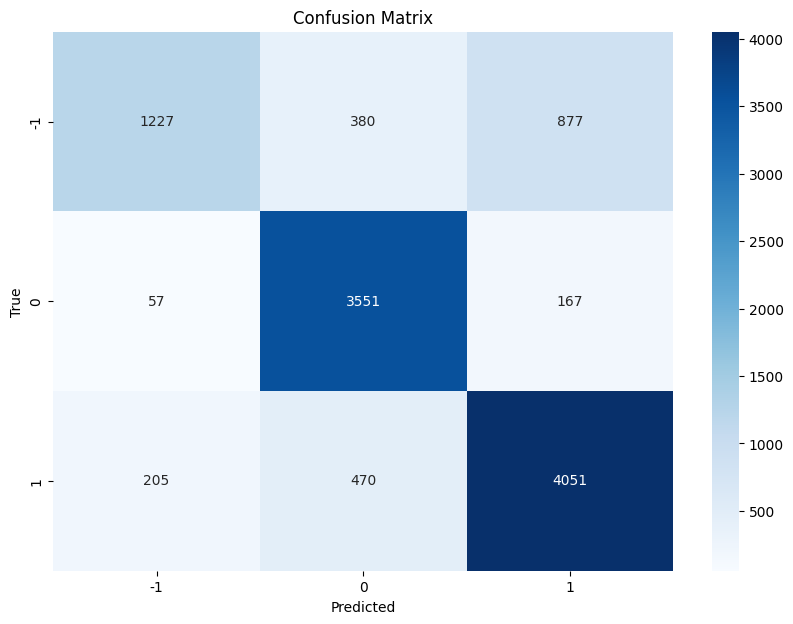

In [ ]:
#  Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the confusion matrix as an image
confusion_matrix_path = "confusion_matrix.png"
plt.savefig(confusion_matrix_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the current notebook
notebook_path = "/content/drive/Baseline_Experiment.ipynb"
# Save the notebook using the file I/O commands (you can also use the Colab UI to save it manually)
!cp /content/Baseline_Experiment.ipynb {notebook_path}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/Baseline_Experiment.ipynb': No such file or directory


In [ ]:

dagshub.init(repo_owner='MitVinay', repo_name='youtube_chrome', mlflow=True)
mlflow.set_experiment("Basline Model")

params = {
    "n_estimators": 100,
    "random_state": 42
}
with mlflow.start_run():
  for key, value in params.items():
      mlflow.log_param(key, value)

  for label, metrics_dict in metrics.items():
      if label != 'accuracy':  # 'accuracy' is logged separately as a single value
          for metric, value in metrics_dict.items():
              mlflow.log_metric(f"{label}_{metric}", value)
      else:
          # Log the accuracy score separately
          mlflow.log_metric("accuracy", metrics_dict)

  mlflow.set_tag("BaseLine Model", "Random Forest")
  model_info = mlflow.sklearn.log_model(
      sk_model=pipe,
      signature=signature,
      input_example=X_train.head(1).to_frame(),
      artifact_path="model",
      registered_model_name="Random forest",
  )
  mlflow.log_artifact(confusion_matrix_path)

Initialized MLflow to track repo "MitVinay/youtube_chrome"

Repository MitVinay/youtube_chrome initialized!

Registered model 'Random forest' already exists. Creating a new version of this model...
2024/12/10 22:01:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random forest, version 4
Created version '4' of model 'Random forest'.


🏃 View run intrigued-eel-785 at: https://dagshub.com/MitVinay/youtube_chrome.mlflow/#/experiments/0/runs/611db727f3e94eeb95706dd4cdaea74f
🧪 View experiment at: https://dagshub.com/MitVinay/youtube_chrome.mlflow/#/experiments/0
